In [1]:
#ignore warning
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

### link doc function

In [2]:
#link docs function
import pandas as pd
cost_file = "Zip_Zhvi_2bedroom.csv"
rev_file = "listings.csv"
city = "New York"

def link_files(cost_file, rev_file, city):

    zillow_data = pd.read_csv(cost_file)
    ny_z=zillow_data[(zillow_data.City == city)]

    Airbnb_data = pd.read_csv(rev_file)
    ny_a=Airbnb_data
    ny_a=ny_a.dropna(subset=['zipcode'])
    ny_a['zipcode'] = ny_a['zipcode'].astype('str')
    ny_a['zipcode'] = ny_a['zipcode'].str.split('-').str[0]
    ny_a['zipcode'] = ny_a['zipcode'].str.split('.').str[0]
    ny_a['zipcode'] = ny_a['zipcode'].str.split('\n').str[0]
    ny_a['zipcode'] = ny_a['zipcode'].astype('int')
    return ny_a.merge(ny_z, left_on='zipcode', right_on='RegionName')

merged=link_files(cost_file, rev_file, city)
merged.shape

(10095, 368)

In [3]:
#take numeric columns and selected categorical cols
numerics = ['int32','int64','float64']
merge_num = merged.select_dtypes(include=numerics)
merge_cate=merged.loc[:,['id','property_type','neighbourhood_group_cleansed','room_type']]
merge=merge_num.merge(merge_cate, left_on='id', right_on='id')

In [4]:
#take only last 1 year's avg prices
merge=pd.concat([merged.ix[:,0:112],merged.ix[:,355:367]], axis=1)
merge['avg_cost']=round(merge.iloc[:,111:123].mean(axis=1),0)
merge.drop(merge.iloc[:, 111:123], inplace = True, axis = 1)
merge['avg_cost']=merge['avg_cost'].astype(int)

### demension deduction

In [5]:
#remove cols with 0 variance or cols containing same info
merge.var()
merge.drop(['listing_url','City', 'State', 'calendar_updated', 'host_thumbnail_url', 'host_name','scrape_id','weekly_price','thumbnail_url','medium_url','xl_picture_url','host_picture_url', 'host_acceptance_rate','calculated_host_listings_count_shared_rooms', 'maximum_minimum_nights', 'has_availability','picture_url', 'host_url','listing_url', 'requires_license', 'license', 'jurisdiction_names', 'instant_bookable',
       'is_business_travel_ready', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification','host_has_profile_pic', 'experiences_offered', 'host_id', 'host_since', 'host_location',
       'host_is_superhost', 'last_scraped', 'name', 'summary', 'description','host_verifications', 'host_identity_verified', 'street','2017-05',
       'neighbourhood', 'neighbourhood_cleansed','host_neighbourhood', 'host_listings_count', 'number_of_reviews_ltm','first_review','Metro'],inplace=True, axis=1)

In [6]:
# drop highly correlated cols >0.8
import numpy as np

corr_matrix = merge.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
merge=merge.drop(merge[to_drop], axis=1)

### missing values

In [7]:
import missingno as msno

max_number_of_nas = len(merge)
clean_data1 = merge.loc[:, (merge.isnull().sum() >  0.0001 * max_number_of_nas)]
clean_data1.isnull().sum()/max_number_of_nas*100

space                          29.678058
neighborhood_overview          37.157008
notes                          61.010401
transit                        38.375433
access                         47.815750
interaction                    45.012382
house_rules                    42.476474
host_about                     39.346211
host_response_time             36.661714
host_response_rate             36.661714
host_total_listings_count       0.059435
city                            0.039624
market                          0.277365
bathrooms                       0.178306
bedrooms                        0.059435
beds                            0.059435
square_feet                    98.920258
monthly_price                  89.063893
security_deposit               34.224864
cleaning_fee                   20.297177
last_review                    22.823180
review_scores_rating           24.536899
review_scores_accuracy         24.586429
review_scores_cleanliness      24.586429
review_scores_ch

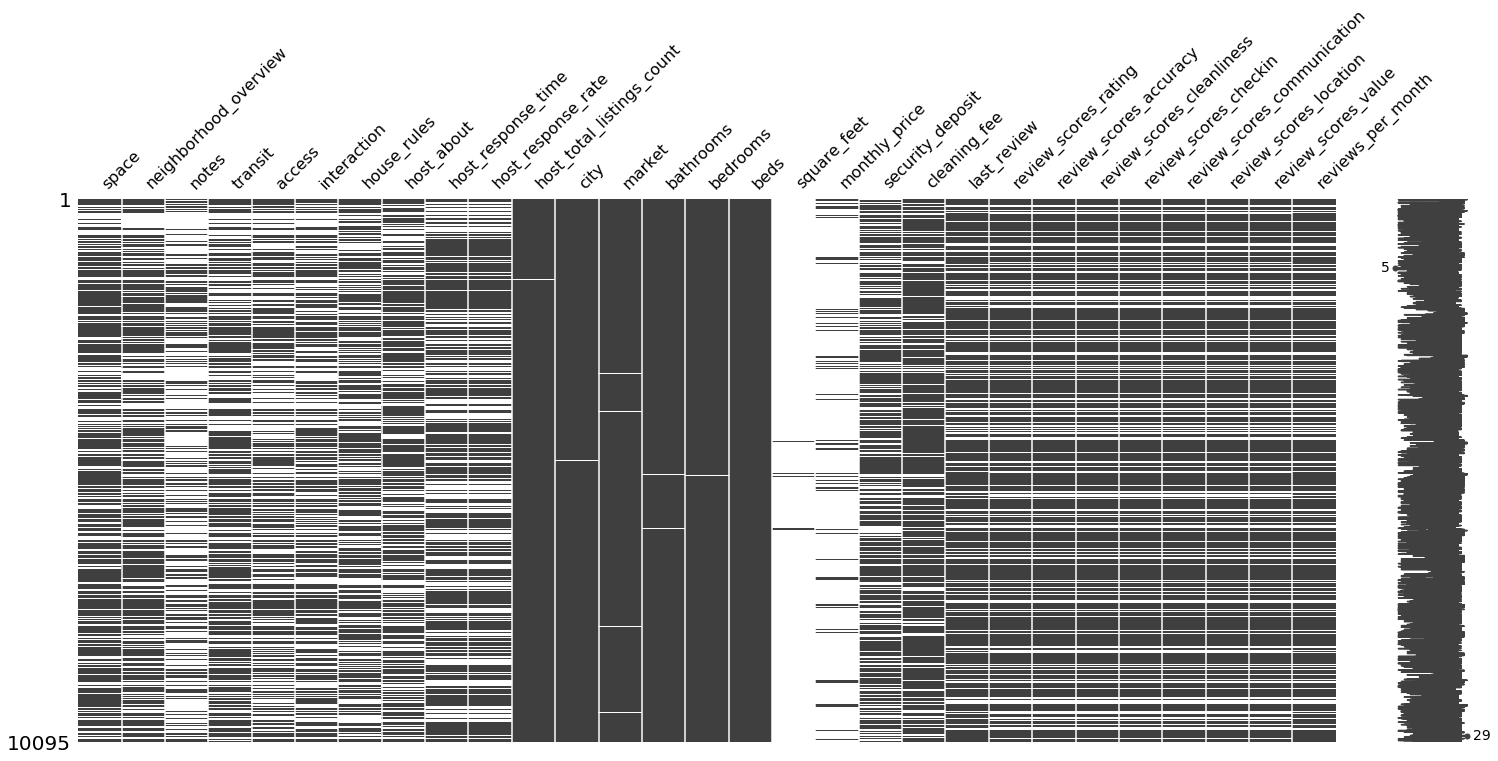

In [8]:
msno.matrix(clean_data1) 

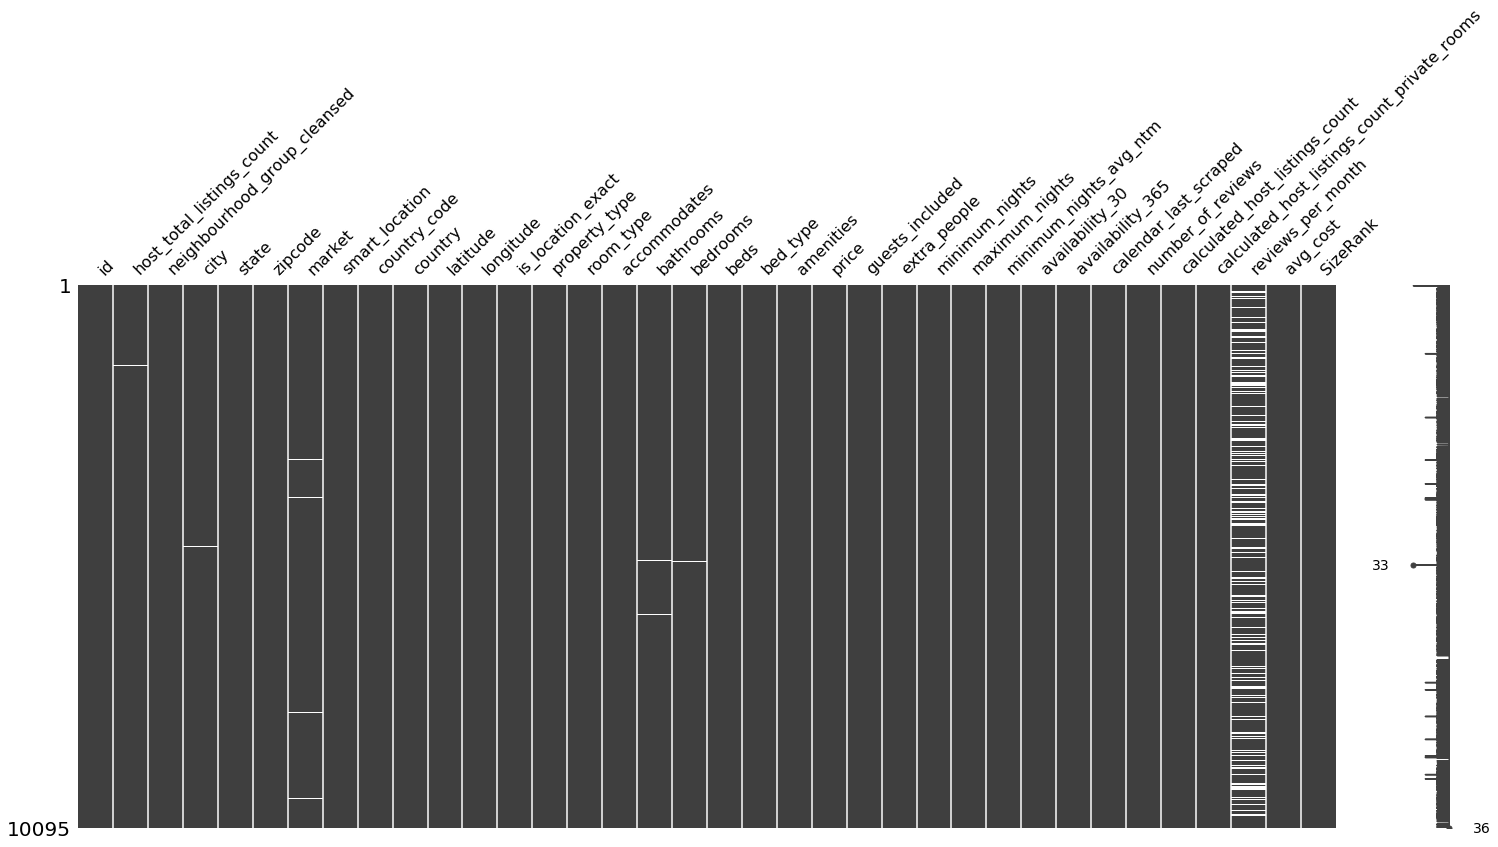

In [9]:
# delete columns with missing values > 24%
# since most of the missing >24% are reviews textual comments, security deposit and host reponse rate
merge = merge.loc[:, (merge.isnull().sum() <  0.24 * max_number_of_nas)]

# remove unwanted columns
#since we take 75% occupancy assumption, we don't need review counts
#cleaning fee is not relevant to profit
merge.drop(columns=['cleaning_fee', 'last_review'], inplace=True)
pop=merged[['id','SizeRank']]
merge=merge.merge(pop, left_on='id', right_on='id')
msno.matrix(merge) 
#plt.show()

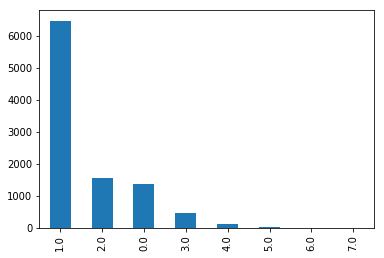

In [10]:
merge['bedrooms'].value_counts().plot('bar')

In [11]:
merge.shape

(10095, 36)

### New Matrics

In [12]:
#take 2 bedrooms property as cost factor baseline
cost_metric=merged.groupby('bedrooms')['beds'].mean().reset_index()
cost_metric[['cost_factor']]=cost_metric[['beds']]/2.432112 
cost_metric=cost_metric[['bedrooms', 'beds', 'cost_factor']]
cost_metric

bedrooms       beds  cost_factor
0       0.0   1.142754     0.469861
1       1.0   1.224455     0.503453
2       2.0   2.380831     0.978915
3       3.0   3.662500     1.505893
4       4.0   5.045113     2.074375
5       5.0   6.083333     2.501255
6       6.0   6.636364     2.728642
7       7.0  10.333333     4.248708

In [13]:
merge_new=merge.merge(cost_metric, left_on='bedrooms', right_on='bedrooms')

### factorized cost = avg property cost * cost factor

In [14]:
merge=merge.merge(cost_metric, left_on='bedrooms', right_on='bedrooms')
merge['factorized_cost']=merge['avg_cost']*merge['cost_factor']

### Annual Revenue = Price * 365 days * 75% occupancy rate

In [15]:
merge['yr_rev']=merge['price']*365*0.75

### Breakeven year = factorized cost / Annual revenue

In [16]:
merge['breakeven_yr']=merge['factorized_cost']/merge['yr_rev']

### Neighbout Level Market Analysis and Visualization

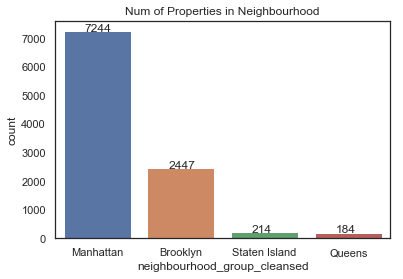

In [18]:
import seaborn as sns

#number of peoperties in each neighbourhood
%matplotlib inline
sns.set(style="white")
ax = sns.countplot(x='neighbourhood_group_cleansed',data=merge,order = merge['neighbourhood_group_cleansed'].value_counts().index) 
plt.title('Num of Properties in Neighbourhood')
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+1))
plt.show()

In [19]:
def groupplot(neighbour,n):
    M_merge=merge.loc[merge['neighbourhood_group_cleansed']==neighbour]
    M_top_zip=M_merge['zipcode'].value_counts()[:n].index.tolist()
    top_M=M_merge.loc[M_merge['zipcode'].isin(M_top_zip)]

    sns.set(style="white")
    ax = sns.countplot(x='zipcode', data=top_M,order = top_M['zipcode'].value_counts().index)
    plt.title('Num of Properties in {}'.format(neighbour))

    for p in ax.patches:
        ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.20, p.get_height()+1))

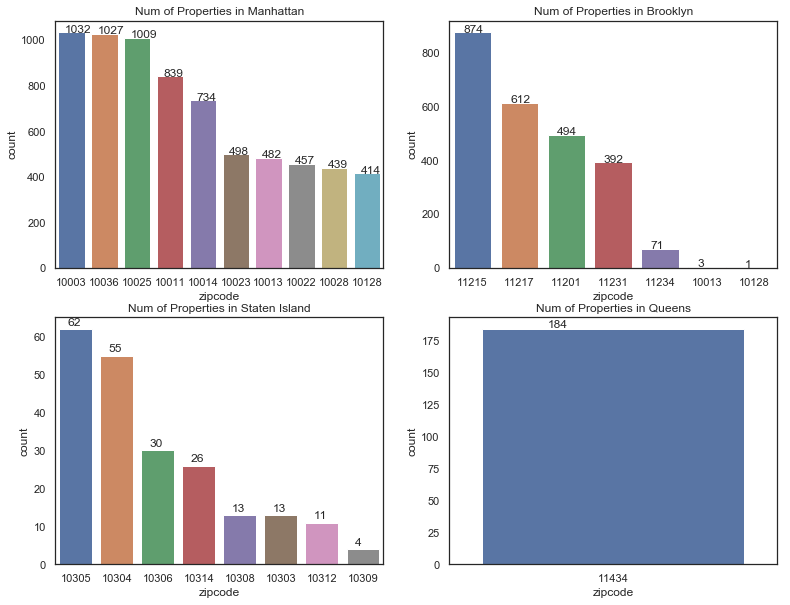

In [20]:
#plot top 10 zipcode with most poperties in each neighbourhood
n = 10
plt.figure(figsize=(20,10))
plt.subplot(231)
groupplot('Manhattan',10)

plt.subplot(232)
groupplot('Brooklyn',10)

plt.subplot(234)
groupplot('Staten Island',10)

plt.subplot(235)
groupplot('Queens',10)

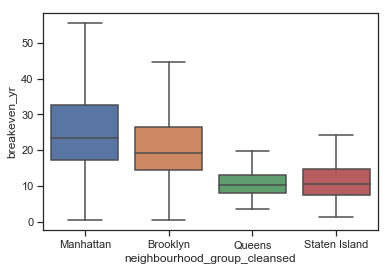

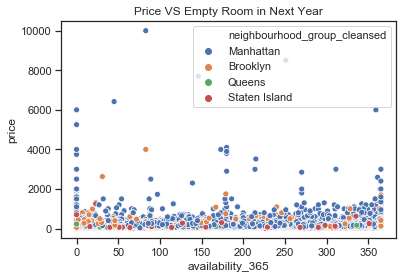

In [21]:
import seaborn
from  matplotlib import pyplot
seaborn.set(style='ticks')
sns.boxplot(data=merge, x='neighbourhood_group_cleansed', y='breakeven_yr', showfliers=False)
plt.show()


#fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1)
#ax.scatter(data=merge, x='availability_365', y='price', s='neighbourhood_group_cleansed')
sns.scatterplot( x="availability_365", y="price", data=merge,  hue='neighbourhood_group_cleansed')
plt.title('Price VS Empty Room in Next Year')
plt.legend(loc='upper right')

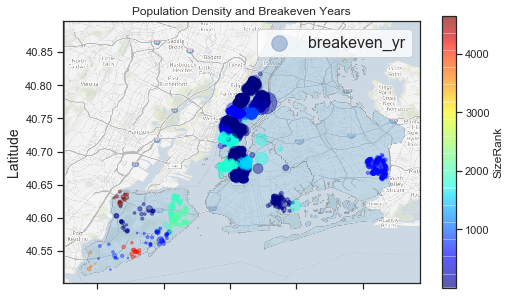

In [31]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

ny_img=mpimg.imread('ny.png')
ax=merge.plot(kind="scatter", x="longitude", y="latitude",
    s=merge["breakeven_yr"], label="breakeven_yr",
    c="SizeRank", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(8,5),
)

plt.imshow(ny_img, extent = [-74.25238,-73.71376, 40.50211,40.89693], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title('Population Density and Breakeven Years')
plt.legend(fontsize=16)


### High Level Summary

 All locations used in analysis for cost and profit are plot based on latitude and longtitude. 
 The dark cold small circles in Staten Island are generally the best investing points 
 with dense population and quick return on investment.

### Zipcode Level Analysis - Manhattan

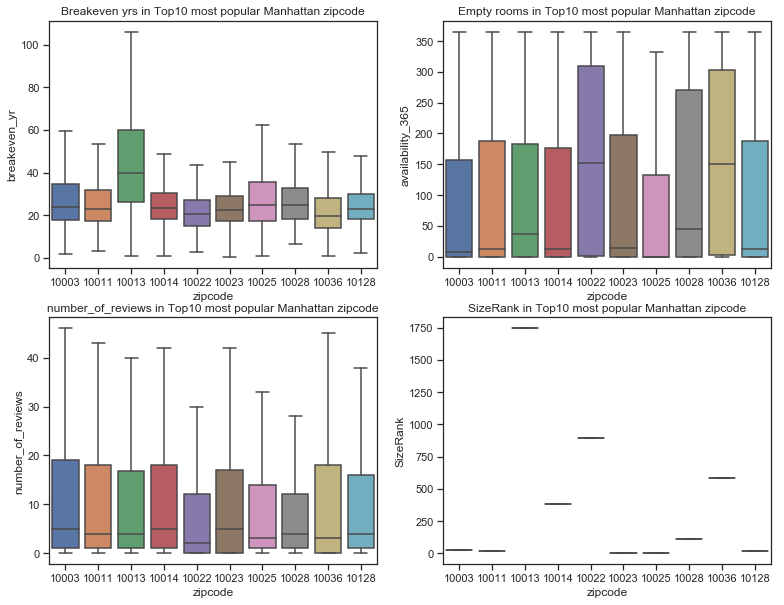

In [22]:
M_merge=merge.loc[merge['neighbourhood_group_cleansed']=='Manhattan']
M_top_zip=M_merge['zipcode'].value_counts()[:10].index.tolist()
top_M=M_merge.loc[M_merge['zipcode'].isin(M_top_zip)]

plt.figure(figsize=(20,10))
plt.subplot(231)
sns.boxplot(data=top_M, x='zipcode', y='breakeven_yr', showfliers=False)
plt.title('Breakeven yrs in Top10 most popular Manhattan zipcode')

plt.subplot(232)
sns.boxplot(data=top_M, x='zipcode', y='availability_365', showfliers=False)
plt.title('Empty rooms in Top10 most popular Manhattan zipcode')

plt.subplot(234)
sns.boxplot(data=top_M, x='zipcode', y='number_of_reviews', showfliers=False)
plt.title('number_of_reviews in Top10 most popular Manhattan zipcode')

plt.subplot(235)
sns.boxplot(data=top_M, x='zipcode', y='SizeRank', showfliers=False)
plt.title('SizeRank in Top10 most popular Manhattan zipcode')

plt.show()

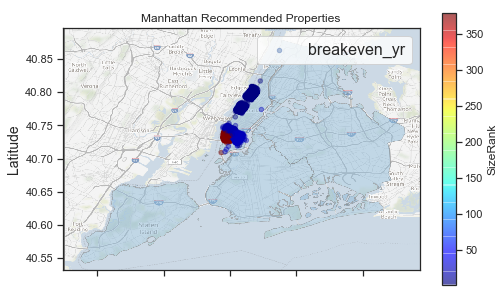

In [23]:
# zipcode with shortest breakeven time:         10011, 10014, 10022, 10023, 10128
# zipcode more likely to get booked in advance: 10025, 10003, 10014, 10128, 10011
# popular zipcode with more guest reviews:      10003, 10011, 10014, 10023, 10036
# zipcode with dense population:                10003, 10011, 10023, 10025, 10128

#summary - Manhattan
Manhattan_zipcode=[10011, 10014, 10003, 10025, 10023]
M_merge= merge[merge['zipcode'].isin(Manhattan_zipcode)]
import matplotlib.image as mpimg
ny_img=mpimg.imread('ny.png')
ax=M_merge.plot(kind="scatter", x="longitude", y="latitude",
     label="breakeven_yr",
    c="SizeRank", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(8,5),
)

plt.imshow(ny_img, extent = [-74.25238,-73.71376, 40.53211,40.89693], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title('Manhattan Recommended Properties')
plt.legend(fontsize=16)


### Zipcode Level Analysis - Brooklyn

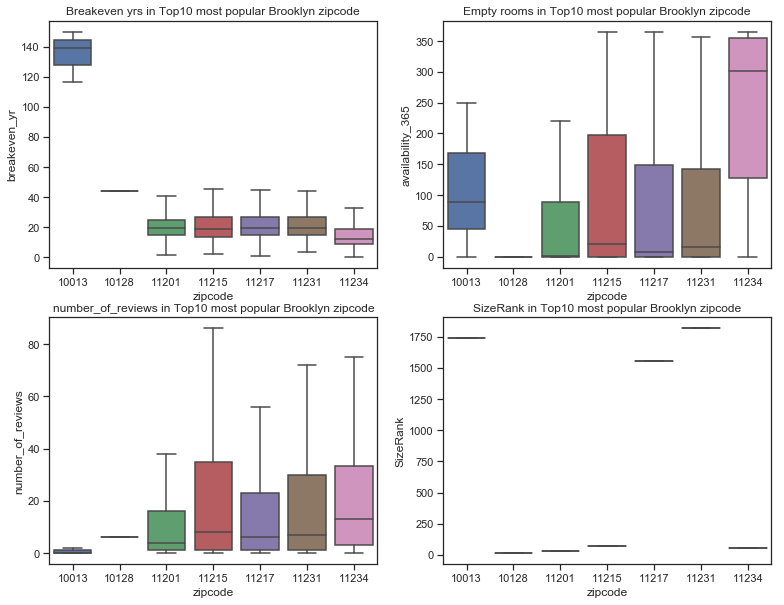

In [24]:
M_merge=merge.loc[merge['neighbourhood_group_cleansed']=='Brooklyn']
M_top_zip=M_merge['zipcode'].value_counts()[:10].index.tolist()
top_M=M_merge.loc[M_merge['zipcode'].isin(M_top_zip)]

plt.figure(figsize=(20,10))
plt.subplot(231)
sns.boxplot(data=top_M, x='zipcode', y='breakeven_yr', showfliers=False)
plt.title('Breakeven yrs in Top10 most popular Brooklyn zipcode')

plt.subplot(232)
sns.boxplot(data=top_M, x='zipcode', y='availability_365', showfliers=False)
plt.title('Empty rooms in Top10 most popular Brooklyn zipcode')

plt.subplot(234)
sns.boxplot(data=top_M, x='zipcode', y='number_of_reviews', showfliers=False)
plt.title('number_of_reviews in Top10 most popular Brooklyn zipcode')

plt.subplot(235)
sns.boxplot(data=top_M, x='zipcode', y='SizeRank', showfliers=False)
plt.title('SizeRank in Top10 most popular Brooklyn zipcode')

plt.show()

In [25]:
a=merge[merge['zipcode']==10023]
a['longitude']

4530    -73.97556
4531    -73.98098
4532    -73.98249
4533    -73.97818
4534    -73.98567
4535    -73.98109
4536    -73.98042
4537    -73.99181
4538    -73.98887
4539    -73.97808
4540    -73.98439
4541    -73.98258
4542    -73.97898
4543    -73.98342
4544    -73.97670
4545    -73.98943
4546    -73.98261
4547    -73.98065
4548    -73.97852
4549    -73.98247
4550    -73.98410
4551    -73.98496
4552    -73.98574
4553    -73.98365
4554    -73.97964
4555    -73.98574
4556    -73.97849
4557    -73.98083
4558    -73.97952
4559    -73.98473
           ...   
9518    -73.98225
9519    -73.97893
9520    -73.98684
9521    -73.98482
9522    -73.98481
9523    -73.98917
9524    -73.98265
9525    -73.98400
9526    -73.97667
9527    -73.98151
9528    -73.98997
9529    -73.98513
9530    -73.98383
9531    -73.97950
9532    -73.97996
9533    -73.97987
9534    -73.97967
9535    -73.98435
9536    -73.99133
9537    -73.98684
9538    -73.98782
9539    -73.97840
9540    -73.98641
9541    -73.98395
9542    -7

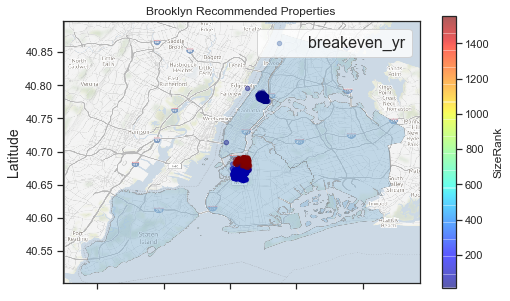

In [26]:
#summary - Brooklyn
Brooklyn_zipcode=[10234, 10128, 11215, 11217]

# zipcode with shortest breakeven time:         10011, 10014, 10022, 10023, 10128
# zipcode more likely to get booked in advance: 10025, 10003, 10014, 10128, 10011
# popular zipcode with more guest reviews:      10003, 10011, 10014, 10023, 10036
# zipcode with dense population:                10003, 10011, 10023, 10025, 10128

#summary - Manhattan
Manhattan_zipcode=[10011, 10014, 10003, 10025, 10023]
B_merge= merge[merge['zipcode'].isin(Brooklyn_zipcode)]
import matplotlib.image as mpimg
ny_img=mpimg.imread('ny.png')
ax=B_merge.plot(kind="scatter", x="longitude", y="latitude",
     label="breakeven_yr",
    c="SizeRank", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(8,5),
)

plt.imshow(ny_img, extent = [-74.25238,-73.71376, 40.50211,40.89693], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title('Brooklyn Recommended Properties')
plt.legend(fontsize=16)


### Zipcode Level Analysis - Staten Island

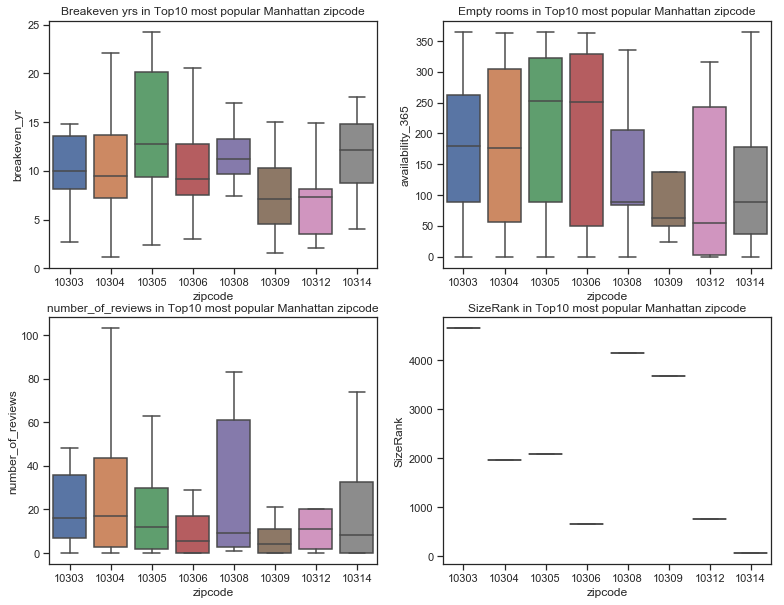

In [27]:
M_merge=merge.loc[merge['neighbourhood_group_cleansed']=='Staten Island']
M_top_zip=M_merge['zipcode'].value_counts()[:10].index.tolist()
top_M=M_merge.loc[M_merge['zipcode'].isin(M_top_zip)]

plt.figure(figsize=(20,10))
plt.subplot(231)
sns.boxplot(data=top_M, x='zipcode', y='breakeven_yr', showfliers=False)
plt.title('Breakeven yrs in Top10 most popular Manhattan zipcode')

plt.subplot(232)
sns.boxplot(data=top_M, x='zipcode', y='availability_365', showfliers=False)
plt.title('Empty rooms in Top10 most popular Manhattan zipcode')

plt.subplot(234)
sns.boxplot(data=top_M, x='zipcode', y='number_of_reviews', showfliers=False)
plt.title('number_of_reviews in Top10 most popular Manhattan zipcode')

plt.subplot(235)
sns.boxplot(data=top_M, x='zipcode', y='SizeRank', showfliers=False)
plt.title('SizeRank in Top10 most popular Manhattan zipcode')

plt.show()

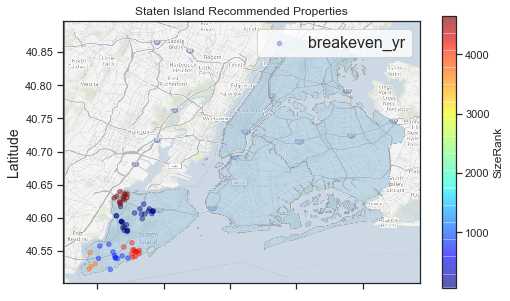

In [28]:
# zipcode with shortest breakeven time:         10312, 10309, 10303, 10306, 10314
# zipcode more likely to get booked in advance: 10309, 10312, 10314, 10308, 10303
# popular zipcode with more guest reviews:      10308, 10304, 10303, 10314, 10305
# zipcode with dense population:                10314, 10312, 10306, 10304, 10305

#summary - Staten Island
StatenIsland_zipcode=[10314, 10312, 10309, 10303, 10308]

SI_merge= merge[merge['zipcode'].isin(StatenIsland_zipcode)]
import matplotlib.image as mpimg
ny_img=mpimg.imread('ny.png')
ax=SI_merge.plot(kind="scatter", x="longitude", y="latitude",
     label="breakeven_yr",
    c="SizeRank", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(8,5),
)

plt.imshow(ny_img, extent = [-74.25238,-73.71376, 40.50211,40.89693], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title('Staten Island Recommended Properties')
plt.legend(fontsize=16)


### Zipcode Level Analysis - Queens

In [29]:
M_merge=merge.loc[merge['neighbourhood_group_cleansed']=='Queens']
M_top_zip=M_merge['zipcode'].value_counts()[:10].index.tolist()
top_M=M_merge.loc[M_merge['zipcode'].isin(M_top_zip)]

plt.figure(figsize=(20,10))
plt.subplot(231)
sns.boxplot(data=top_M, x='zipcode', y='breakeven_yr', showfliers=False)
plt.title('Breakeven yrs in Top10 most popular Manhattan zipcode')

plt.subplot(232)
sns.boxplot(data=top_M, x='zipcode', y='availability_365', showfliers=False)
plt.title('Empty rooms in Top10 most popular Manhattan zipcode')

plt.subplot(234)
sns.boxplot(data=top_M, x='zipcode', y='number_of_reviews', showfliers=False)
plt.title('number_of_reviews in Top10 most popular Manhattan zipcode')

plt.subplot(235)
sns.boxplot(data=top_M, x='zipcode', y='SizeRank', showfliers=False)
plt.title('SizeRank in Top10 most popular Manhattan zipcode')

plt.show()

In [30]:
#summary - Staten Island'
Queens_zipcode=[11434]

Q_merge= merge[merge['zipcode'].isin(Queens_zipcode)]
import matplotlib.image as mpimg
ny_img=mpimg.imread('ny.png')
ax=Q_merge.plot(kind="scatter", x="longitude", y="latitude",
     label="breakeven_yr",
    c="SizeRank", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(8,5),
)

plt.imshow(ny_img, extent = [-74.25238,-73.71376, 40.50211,40.89693], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title('Queens Recommended Properties')
plt.legend(fontsize=16)


### Neighborhood Level Summary

•	Manhattan

In Manhattan, more people are willing to pay for higher price and 2B properties available in numerous zipcode
but still a large number of house are unoccupied with price around $1000. And it takes 20-30 yrs to breakeven
It is a riskier market to enter.

It is a higher risk slow return market with diverse choices and dense population to fit any business type, especially the luxury services. Recommend zip code 10011, 10014, 10003, 10025, 10023.

•	Brooklyn

Brooklyn has second highest price on avg. Rooms are booked more often than Manhattan, and it takes around 20 yrs to breakeven.
Medium risk market which is more stable than Manhattan. But it is not top choice for business looking for short return. Recommend for business looking for long term profit on zip code 10011, 10014, 10003, 10025 and 10023.

•	Staten Island (Best Fit)

A stable and under-developed market. Good choice for business looking for short term return without bearing high risk. It takes around 10 yrs to breakeven. This market is the best fit according to business context. Recommend on zip code 10314, 10312, 10309, 10303 and 10308.

•	Queens

Queens has lower price and occupancy is at median. It takes less than 10 yrs to breakeven.For business looking for short term profit in a monopoly market with limited choices, the recommendation zip code is on 11434.
